## Automatic differentiation and sensitivities
[Differentiable programming](https://en.wikipedia.org/wiki/Differentiable_programming) is one of the technologies that have fueled the recent deep learning revolutions. It allows for the automatic computation of derivatives (gradients) of functions with respect to their inputs. This is particularly relevant for gradient-based optimization algorithms such as the ones commonly used to train machine learning models. In finance and business applications, differentiable programming can greatly simplify [sensitivity analysis](https://en.wikipedia.org/wiki/Sensitivity_analysis) by removing the need to compute partial derivatives by hand. Concretely, if the value $V$ of a certain contract depends for instance on a sales forecast $S$ and some rate of return $r$,

$$
V = f(S, r),
$$

the impact of small changes in the underlying variables can be estimated through a first-order approximation,

$$
\Delta V = \frac{\partial f}{\partial S} \Delta S + \frac{\partial f}{\partial r} \Delta r,
$$

which should be straightforward to compute in a differentiable programming library such as JAX through the application of the `grad` operator.

In [1]:
#| echo: false
#| output: false
from jax import grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd
import seaborn as sns

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [2]:
from jax import grad
import jax.numpy as jnp

def contract_value(sales_forecast, discount_rate):
    time = jnp.arange(54)/2
    market_time = jnp.arange(1, 42)/2
    discount_curve = (1 + discount_rate)**(-time)
    market_penetration_curve = jnp.concatenate(
        [jnp.zeros(13),
         jnp.sin((market_time-.1)/8)
           * jnp.minimum(1, jnp.exp(-(market_time-15)/3))
        ])
    return jnp.sum(sales_forecast * market_penetration_curve * discount_curve)

estimated_value = contract_value(100., .1)
sensitivities = grad(contract_value, argnums=[0, 1])(100., .1)

print(f'estimated value: {estimated_value}')
print(f'sales sensitivity: {sensitivities[0]}')
print(f'rate sensitivity: {sensitivities[1]}')

estimated value: 554.726806640625
sales sensitivity: 5.547268867492676
rate sensitivity: -7496.2802734375


Sensitivity analysis is important to inform investment decisions and risk management, so there is no question here about the benefits of automatic differentiation. Furthermore, functions in differentiable programming are chainable, and derivatives automatically follow the [chain rule](https://en.wikipedia.org/wiki/Chain_rule). So if the sales forecast is given by another function, for instance `sales_forecast_fn(temperature, store_location)`, one can compose them to find the sentivity to the temperature.

In [3]:
def sales_forecast_fn(temperature, store_location):
    return jnp.exp(temperature) #this is an ice cream business

def contract_value_2(discount_rate, temperature, store_location):
    return contract_value(sales_forecast_fn(temperature, store_location),
                          discount_rate)

sensitivity_temperature = grad(contract_value_2, argnums=1)(.1, 10., 'Basel')

In particular, this also works when `sales_forecast_fn` is a differentiable machine learning model such as a neural network, so one can combine financial models with machine learning forecast models of their input variables.

Maybe more interestingly, the finance team can then focus on the value functions and their financial input, while the commercial team is responsible for the sales forecast, and the differentiable programming framework will ensure the compatibility of the models and the backpropagation of sensitivities.

### Sidenote on discrete variables
The `store_location` variable was not used here because it is discrete and differentiation only works for continuous numerical variables. It was added as an example of a limitation of sensitivity analysis through automatic differentiation. In the case of discrete variables, the concept of "small change" does not make sense anyway, and analysing distributions of contract values conditioned on the store location is going to be informative enough for the purpose of risk management and investment decisions.

## Probabilistic programming and Monte Carlo simulations
Even for continuous variables, sensitivity analysis through partial derivatives only works for small changes. The next stage of risk management is to build a probabilistic risk model of the joint distribution of input variables and estimate their effect on the output of the value function through [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) simulation.

This used to be a tedious process, especially with multiple correlated random variables. Surprisingly, differentiable programming has also indirectly simplified that process. The recent years have seen the development of several [probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming) libraries built on top of differentiable programming libraries. The reason is that automatic differentiation greatly facilitates the implementation of gradient-based inference algorithms such as Hamiltonian Monte Carlo and variational inference, so there has been a push to streamline the whole analysis process.

In probabilistic programming, probabilistic models are specified in computer code, and inference is performed more or less automatically. The probabilistic models prescribe ways to draw samples of the probability distributions they encode, and to evaluate the probability density of observations. In the context of risk management, it is enough to express the risk model as a probabilistic program, and the sampling methods will perform Monte Carlo simulations automatically, as illustrated in the following example.

Again, the composability of differentiable programs makes it easy to connect a risk model to other parts of an analytics pipeline.

## Drug development
Estimating the value of a drug development program is the archetypical example of a valuation problem where probability distributions play an important role due to the stochastic nature of the whole process. Clinical development traditionally follows different trial phases to derisk the program medically and financially. The success of each phase determines if there will be investment in the next one, and ultimately if the drug will be commercialized and bring in revenue. The industry standard methodology for this valuation is the [risk-adjusted net present value (rNPV)](https://en.wikipedia.org/wiki/Risk-adjusted_net_present_value), where every discounted future cash flow is weighted by the probability that it actually occurs. In other words, it is the expectation value of the random variable representing the sum of discounted future cash flows.

Sources of randomness in the NPV of a drug in development include the success or failure of different phases, that can be modelled by Bernoulli random variables, and the uncertainty in the parameters of the valuation model.

In [4]:
#| echo: false
#| output: false
length = jnp.array([1, 2, 2, 1.5])
dev_cost_estimate = jnp.array([4., 15., 45., 2.])
success_rate = jnp.array([.66, .39, .62, .75])

time = jnp.arange(54)/2

In [5]:
#| echo: false
df = pd.DataFrame({'stage': ['phase 1', 'phase 2', 'phase 3', 'regulatory submission'],
                   'estimated cost': dev_cost_estimate,
                   'duration': length,
                   'success rate': success_rate
                  }).set_index('stage')
df

,estimated cost,duration,success rate
stage,,,
phase 1,4.0,1.0,0.66
phase 2,15.0,2.0,0.39
phase 3,45.0,2.0,0.62
regulatory submission,2.0,1.5,0.75


The volume of sales is particularly hard to estimate as it varies over time and the forecast has to be made a few years in advance. A common way to approach this problem, which was implemented in the `contract_value` function defined above, is to model with a normalized sales curve the market penetration and then the decay following the end of life of the patent and the entrance of competitors in the market. This sales curve can be empirically derived from previous launches, or artistically constructed like in the example shown here.

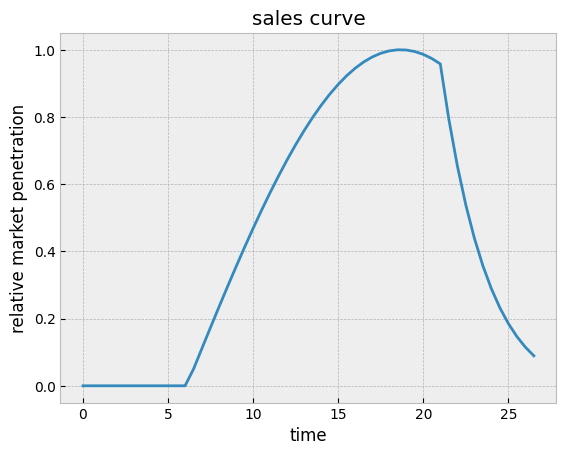

In [6]:
#| echo: false
year = jnp.arange(1, 42)/2
discount = .15

sales_curve = jnp.sin((year-.1)/8) * jnp.minimum(1, jnp.exp(-(year-15)/3))
sales_curve = jnp.concatenate([jnp.zeros(13), sales_curve])

discount_curve = (1 + discount)**(-time)

plt.plot(time, sales_curve)
plt.xlabel('time')
plt.ylabel('relative market penetration')
plt.title('sales curve')
plt.show()

The sales can then be modelled with a single random variable, the peak sales, that will be multiplied by the sales curve. Since the estimation of the peak sales can vary over time because of external market conditions, modelling it as a stochastic process is a reasonable assumption. In practice, a geometric Brownian motion is a practical and realistic choice.

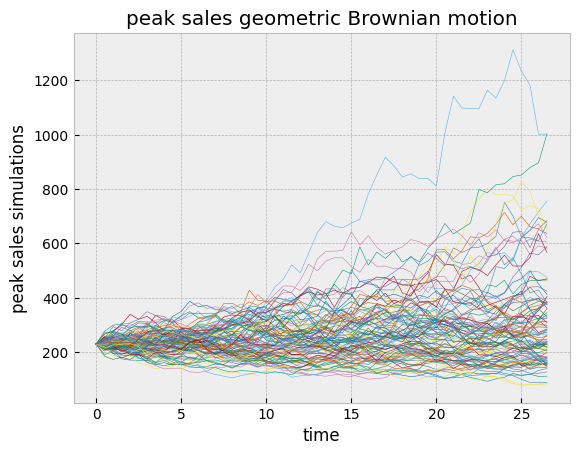

In [7]:
#| echo: false
key = random.PRNGKey(0)

growth = .01
volatility = .10
time_step = .5

peak_sales_estimate = 230.

brownian_motion = tfd.MarkovChain(
    initial_state_prior=tfd.Deterministic(0.),
    transition_fn=lambda _, x: tfd.Normal(loc=x + (growth - volatility**2/2) * time_step, scale=volatility*jnp.sqrt(time_step)),
    num_steps=54,
    name='brownian_motion')

bms = brownian_motion.sample(10000, seed=key)

for i in range(100):
    plt.plot(time, peak_sales_estimate * jnp.exp(bms[i]), linewidth=0.4)
plt.xlabel('time')
plt.ylabel('peak sales simulations')
plt.title('peak sales geometric Brownian motion')
plt.show()

The variance increases over time, reflecting the increasing uncertainty of longer and longer forecasts.

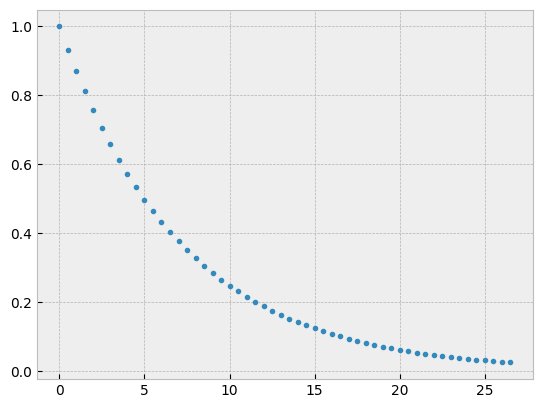

In [8]:
#| echo: false
#| output: false
plt.plot(time, discount_curve, '.')

In [9]:
#| echo: false
#| output: false
launch_cost_estimate = 100.
margin = .55
growth = .01
volatility = .10
discount_rate = .15
time_step = .5
peak_sales_estimate = 230.

discount_curve = (1 + discount)**(-time)

But when this peak sales stochastic process gets multiplied by the sales curve and the discount curve, the long term variance gets squeezed.

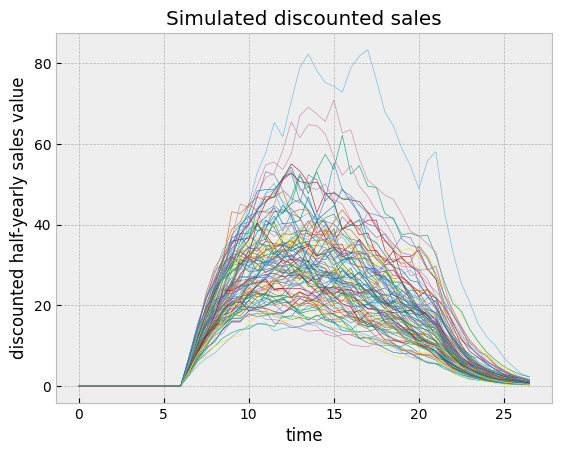

In [10]:
#| echo: false
for i in range(100):
    plt.plot(time, peak_sales_estimate * jnp.exp(bms[i]) * sales_curve * discount_curve, linewidth=0.4)
plt.xlabel('time')
plt.ylabel('discounted half-yearly sales value')
plt.title('Simulated discounted sales')
plt.show()

This somewhat controls the distribution of discounted total revenues.

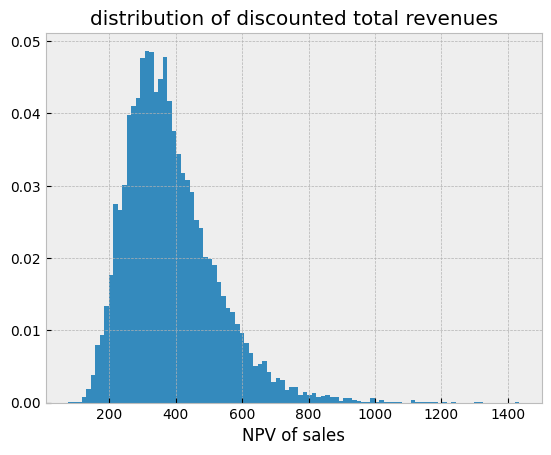

In [11]:
#| echo: false
plt.hist(jnp.sum(0.5 * peak_sales_estimate * jnp.exp(bms) * sales_curve * discount_curve, axis=-1), bins=100, weights=jnp.ones(bms.shape[0])/bms.shape[0])
# the 0.5 factor comes from the 0.5y time resolution of sales forecasts, while peak_sales is a yearly estimate
plt.xlabel('NPV of sales')
plt.title('distribution of discounted total revenues')
plt.show()

The probabilistic financial model can be implemented as a [TensorFlow Probability](https://www.tensorflow.org/probability) joint distribution parameterized by a [distribution-making generator](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutine). This is well-suited for Monte Carlo simulations as mathematical operations can be directly expressed in JAX or TensorFlow code depending on the backend, while `tensorflow_probability.distributions` objects handle the random variables in the model.

Here it is assumed that the success rates and durations of clinical trial phases are known, but that the costs come with a 5% uncertainty and follow a normal distribution. Some metrics are extracted as `tfd.Deterministic` distributions so that they are recorded at sampling, the last one being the NPV of each realization of the simulator. The peak sales are modelled as a geometric Brownian motion as discussed above. If $S_t$ obeys the stochastic differential equation

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

of a geometric Brownian motion, then its solution is given by

$$
S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t},
$$

which for discrete observations can be implemented as an exponentiated Markov chain with normal updates.

In [12]:
#| code-fold: true
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

key = random.PRNGKey(0)
N_SAMPLE = 1000000

Root = tfd.JointDistributionCoroutineAutoBatched.Root

def simulate_npv(dev_cost_estimate,
                 launch_cost_estimate,
                 success_rate,
                 peak_sales_estimate,
                 growth, volatility,
                 discount_rate):
    """
    Returns a Monte Carlo sample of NPV scenarios along with
    certain relevant metrics.
    Implemented with a TensorFlow Probability joint distribution.
    """
    launch_cost_estimate = jnp.array(launch_cost_estimate).reshape((1,))
    dev_cost_std = 0.05 * dev_cost_estimate
    launch_cost_std = 0.05 * launch_cost_estimate
    
    discount_curve = (1 + discount_rate)**(-time)
    
    @tfd.JointDistributionCoroutineAutoBatched
    def cash_flow_model():
        dev_cost = yield Root(tfd.Independent(tfd.Normal(dev_cost_estimate,
                                                         dev_cost_std),
                                              reinterpreted_batch_ndims=1,
                                              name='dev_cost'))
        launch_cost = yield Root(tfd.Normal(launch_cost_estimate,
                                            launch_cost_std,
                                            name='launch_cost'))
        success = yield Root(tfd.Independent(tfd.Bernoulli(probs=success_rate),
                                             reinterpreted_batch_ndims=1,
                                             name='success'))
        cash_flow_mask = jnp.cumprod(success, axis=-1)
        cash_flow_mask = jnp.concatenate([jnp.array([1]),
                                          cash_flow_mask],
                                         axis=-1)
        yield tfd.Deterministic(cash_flow_mask,
                                name='cash_flow_mask')

        brownian_motion = yield Root(tfd.MarkovChain(
            initial_state_prior=tfd.Deterministic(0.),
            transition_fn=lambda _, x: tfd.Normal(
                loc=x + (growth - volatility**2/2) * time_step,
                scale=volatility*jnp.sqrt(time_step)),
            num_steps=54,
            name='brownian_motion'))

        peak_sales = peak_sales_estimate * jnp.exp(brownian_motion)

        sales = peak_sales * sales_curve * time_step
        discounted_sales = sales * discount_curve
        sales_npv = jnp.sum(discounted_sales, axis=-1)
        yield tfd.Deterministic(sales_npv, name='sales_npv')

        cost_discount = (1 + discount_rate)**(
            -jnp.concatenate([jnp.array([0.]), jnp.cumsum(length)]))
        discounted_cost = jnp.concatenate([dev_cost,
                                           launch_cost],
                                          axis=-1) * cost_discount
        yield tfd.Deterministic(discounted_cost, name='discounted_cost')

        NPV = (sales_npv * margin * cash_flow_mask[..., -1]
               - jnp.sum(discounted_cost * cash_flow_mask, axis=-1))

        yield tfd.Deterministic(NPV, name='NPV')
    
    s = cash_flow_model.sample(N_SAMPLE, seed=key)
    return s

A histogram of the simulated NPV reveals four clusters, three of them corresponding to simulated failed programs, and a more diffuse one corresponding to the simulations that made it to commercialization.

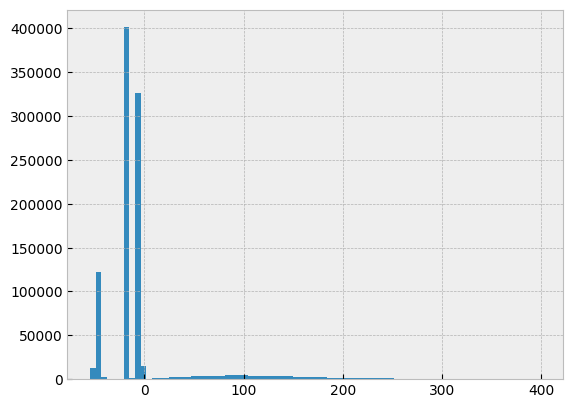

In [13]:
#| echo: false
s = simulate_npv(dev_cost_estimate, launch_cost_estimate, success_rate, peak_sales_estimate, growth, volatility, discount_rate)
plt.hist(jnp.minimum(s.NPV, 400), bins=80)
plt.show()

Focusing only on the failed ones shows that the phase 3 and submission failures form a single cluster due to the relatively low submission cost.

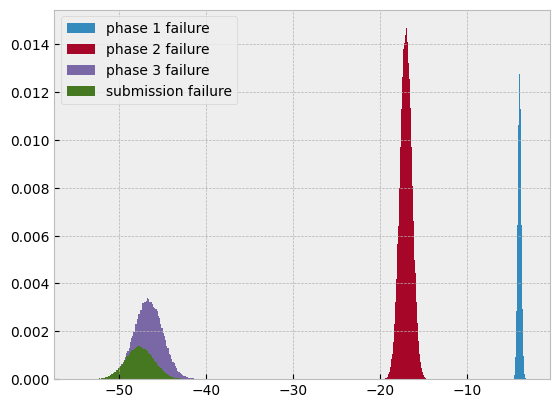

In [14]:
#| echo: false
mode_label = jnp.sum(s.cash_flow_mask, axis=1)
labels = ['phase 1 failure',
          'phase 2 failure',
          'phase 3 failure',
          'submission failure'
         ]
for i in range(4):
    npv = s.NPV[mode_label==i+1]
    plt.hist(npv, weights=jnp.ones_like(npv)/s.NPV.shape[0], label=labels[i], bins=100)
plt.legend()
plt.show()

## Risk management through diversification
While the rNPV is really only a crude summary statistics of the distribution of potential outcomes, Monte Carlo simulations reveal how risky these investments can be and provide insights on how to mitigate those risks. The most immediate action is diversification. It reduces the variance and eventually merges the clusters. A simple model of a portfolio of 10 independent copies of the same drug development program considered above illustrates this mechanism.

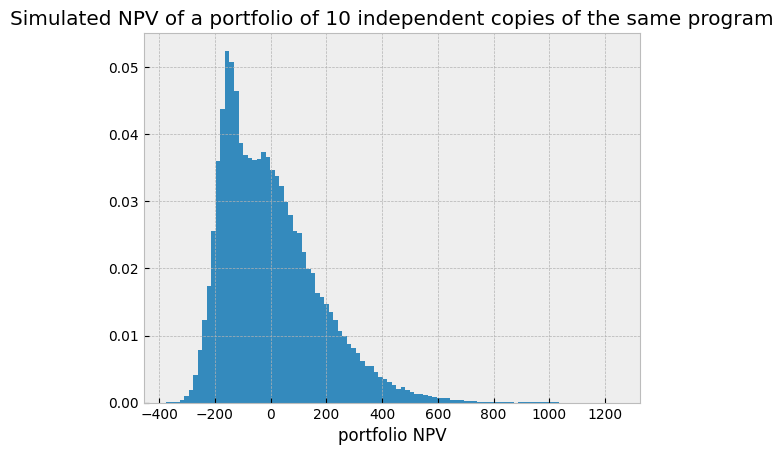

In [15]:
#| echo: false
pf_10 = jnp.sum(s.NPV.reshape((10, -1)), axis=0)
plt.hist(pf_10, bins=100, weights=jnp.ones_like(pf_10)/pf_10.shape[0])
plt.title('Simulated NPV of a portfolio of 10 independent copies of the same program')
plt.xlabel('portfolio NPV')
plt.show()

The variance is reduced, but the probability of a negative value is still fairly high. If squeezing the variance tighter through even more diversification would help, shifting the distribution to the right through active optimization of its mean might be easier (and much cheaper) to implement.

## Active optimization of the expected return
This is where differentiable programming and probabilistic programming nicely come together. The Monte Carlo estimation of the rNPV, which is the mean of the net present values of the simulated scenarios, is itself expressed in a differentiable program, and one can automatically compute its sensitivities.

In [16]:
#| echo: false
#| output: false
def estimate_rNPV(dev_cost_estimate,
                  launch_cost_estimate,
                  success_rate,
                  peak_sales_estimate,
                  growth, volatility,
                  discount_rate):
    s = simulate_npv(dev_cost_estimate,
                     launch_cost_estimate,
                     success_rate,
                     peak_sales_estimate,
                     growth,
                     volatility,
                     discount_rate)
    return jnp.mean(s.NPV)

sensitivity_success_rate = grad(estimate_rNPV, argnums=[2])(
    dev_cost_estimate,
    launch_cost_estimate,
    success_rate,
    peak_sales_estimate,
    growth,
    volatility,
    discount_rate)
print(sensitivity_success_rate)

(Array([0., 0., 0., 0.], dtype=float32),)


A subtle technicality here is that the realizations of Bernoulli random variables are discrete and obstruct the propagation of gradients, but one can use the probabilities instead to build a differentiation-friendly estimator.

In [17]:
#| code-fold: true
def compute_rNPV(dev_cost_estimate,
                 launch_cost_estimate,
                 success_rate,
                 peak_sales_estimate,
                 growth, volatility,
                 discount_rate):
    
    s = simulate_npv(dev_cost_estimate,
                     launch_cost_estimate,
                     success_rate,
                     peak_sales_estimate,
                     growth, volatility,
                     discount_rate)
    
    probs = jnp.concatenate([jnp.ones((1,)),
                             jnp.cumprod(success_rate)])
    
    return jnp.mean(probs[-1] * s.sales_npv * margin
                    - jnp.sum(probs * s.discounted_cost, axis=-1))

rNPV_sensitivities = grad(compute_rNPV, argnums=[0, 1, 2, 3, 4, 5])(
     dev_cost_estimate,
     launch_cost_estimate,
     success_rate,
     peak_sales_estimate,
     growth, volatility,
     discount_rate)

In practice, one cannot really directly change these variables, so at first glance these sensitivities are not very actionable. However, operational decisions on the execution of the trials typically involve trade-offs that can be hard to optimize. This problem can be addressed with differentiable chainable models. For instance, increasing the sample size should improve the success rate, which drives the rNPV up, but at the same time it increases costs and potentially delays commercialization, which drives the rNPV down. The overall change can be estimated by chaining the `compute_rNPV` function with `dev_cost(sample_size)` and `success_rate(sample_size)` functions, and computing the gradient with respect to the sample size variable.

Arguably, the models presented here have been known for a while, yet they are not always being used to their full potential in industry settings due to the technical challenges to implement them. By providing user-friendly APIs for Monte Carlo simulations and sensitivity computations, differentiable programming libraries will hopefully change that.

## Further readings
- The [Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) covers differentiable programming in JAX.
- The example was inspired by an exercise from [Valuation in Life Sciences](https://link.springer.com/book/10.1007/978-3-642-10820-4), which discusses various valuation methods.